### Dataset

https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset

### Import Libraries

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.color import rgb2lab, lab2rgb
from tensorflow.python.keras.layers import Input

### Load and preprocess the data

In [2]:
# Directories 
train_black_dir = 'data/train_black'
train_color_dir = 'data/train_color'
test_black_dir = 'data/test_black'
test_color_dir = 'data/test_color'

img_height, img_width = 400, 400

# Helper function to load images and preprocess them
def load_images(img_dir, color_mode='grayscale'):
    images = []
    filenames = sorted(os.listdir(img_dir))
    for filename in filenames:
        img_path = os.path.join(img_dir, filename)
        img = load_img(img_path, target_size=(img_height, img_width), color_mode=color_mode)
        img = img_to_array(img)
        if color_mode == 'rgb':
            img = rgb2lab(img / 255.0)[:,:,0]  # Extract L channel
        images.append(img)
    return np.array(images, dtype=float)

### Load and preprocess the data

In [7]:
train_black_images = load_images(train_black_dir, color_mode='grayscale')
train_color_images = load_images(train_color_dir, color_mode='rgb')
test_black_images = load_images(test_black_dir, color_mode='grayscale')
test_color_images = load_images(test_color_dir, color_mode='rgb')

# Normalize images
# train_black_images = train_black_images / 255.0
# train_color_images = train_color_images / 255.0
# test_black_images = test_black_images / 255.0
# test_color_images = test_color_images / 255.0

### # Data augmentation for better generalization

In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True 

)
datagen.fit(train_black_images)

### Data Statistics and Exploration

Training black and white images: (5000, 400, 400, 1)
Training color images: (5000, 400, 400)
Test black and white images: (739, 400, 400, 1)
Test color images: (739, 400, 400)


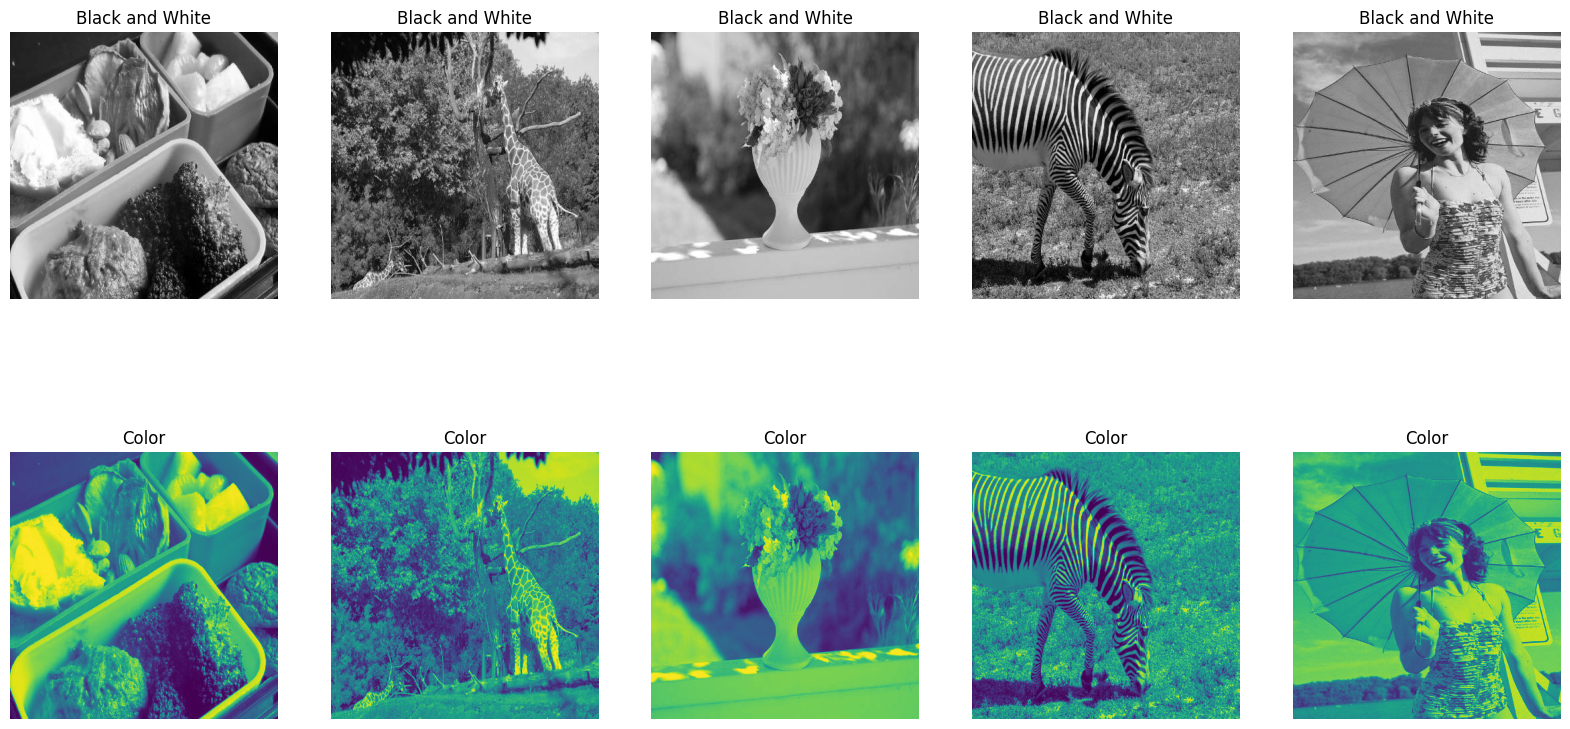

In [6]:
# Display basic statistics about the dataset
print(f'Training black and white images: {train_black_images.shape}')
print(f'Training color images: {train_color_images.shape}')
print(f'Test black and white images: {test_black_images.shape}')
print(f'Test color images: {test_color_images.shape}')

# Function to display a few images
def display_images(bw_images, color_images, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Display black and white image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(bw_images[i].reshape(img_height, img_width), cmap='gray')
        plt.title("Black and White")
        plt.axis("off")

        # Display color image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(color_images[i])
        plt.title("Color")
        plt.axis("off")

display_images(train_black_images, train_color_images)

### 2. Model Architecture (Transfer Learning + Custom)

In [15]:
# Model Architecture
input_shape = (img_height, img_width, 1)  # Grayscale input
input_img = Input(shape=input_shape)

# VGG16 Base (Transfer Learning)
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
vgg.trainable = False  # Freeze VGG layers

# Custom Colorization Layers
vgg_features = vgg(tf.image.grayscale_to_rgb(input_img))
x = Conv2D(256, (3, 3), activation='relu', padding='same')(vgg_features)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # Additional upsampling to match the input size
x = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)  # Output 2 channels (ab)

# Ensure the dimensions match before concatenation
print(f"Shape of input L channel: {input_img.shape}")
print(f"Shape of ab channels before concatenation: {x.shape}")

# Combine with L channel
output_img = Lambda(combine_l_ab)([input_img, x])

# Model
# model = Model(inputs=input_img, outputs=output_img)

The following Variables were used a Lambda layer's call (tf.nn.convolution_18), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_19), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.nn.convolution_20), but
are not present in its tracked objects:
  <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
It is pos

ValueError: Exception encountered when calling Lambda.call().

[1mDimension 1 in both shapes must be equal, but are 400 and 192. Shapes are [?,400,400] and [?,192,192]. for '{{node tf.concat_1/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](Placeholder, Placeholder_1, tf.concat_1/concat/axis)' with input shapes: [?,400,400,1], [?,192,192,2], [] and with computed input tensors: input[2] = <-1>.[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(None, 400, 400, 1), dtype=float32)', 'tf.Tensor(shape=(None, 192, 192, 2), dtype=float32)']
  • mask=['None', 'None']
  • training=None

### Train the model

In [36]:
# Train the model
model.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=5, min_lr=0.00001)

ValueError: Unrecognized type for `inputs`: KerasTensor(type_spec=TensorSpec(shape=(None, 400, 400, 1), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'") (of type <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>)

### Evaluate the model

In [ ]:
# Evaluate the model
test_loss = model.evaluate(test_black_images, test_color_images)
print(f'Test Loss: {test_loss}')

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'],   
 loc='upper right')
plt.show()

In [ ]:
def display_results(bw_images, color_images, predictions, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Display original black and white image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(bw_images[i].reshape(img_height, img_width), cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Display colorized image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(lab2rgb(np.concatenate([bw_images[i].reshape(img_height, img_width, 1), predictions[i] * 128], axis=-1)))
        plt.title("Colorized")
        plt.axis("off")

        # Display ground truth color image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(lab2rgb(color_images[i]))
        plt.title("Ground Truth")
        plt.axis("off")

# Get predictions on test set
predictions = model.predict(test_black_images)

# Display results
display_results(test_black_images, test_color_images, predictions)